<a href="https://colab.research.google.com/github/LebowskiSama/Landscape_GAN/blob/main/landscape_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the dataset

In [ ]:
# Jovian backed lib
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/arnaud58/landscape-pictures")

  3%|▎         | 17.0M/620M [00:00<00:06, 95.2MB/s]

100%|██████████| 620M/620M [00:03<00:00, 217MB/s]


# Load the image library as tensors after resizing and normalizing

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Mean tuple & Std. Variation tuple

# Display loaded landscapes for reference and verification

In [ ]:
train_dataset = ImageFolder("./dataset",transform= T.Compose([ # to apply multiple variations at once
                            T.Resize(image_size),
                            T.CenterCrop(image_size),
                            T.ToTensor(),
                            T.Normalize(*normalization_stats)])
                            )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denormalize(image_tensors):
    return image_tensors * normalization_stats[1][0] + normalization_stats[0][0]

In [ ]:
def plot_images(images, n=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([]) # Remove ticks on the axes
    ax.imshow(make_grid(denormalize(images.detach()[:n]), nrow=8).permute(1, 2, 0))

def show_batch(dataloader, n=64):
    for images, _ in dataloader:
        plot_images(images, n)
        break

In [ ]:
for images, _ in train_dataloader:
    print(images.shape) # Verify image dimensions
    break

torch.Size([128, 3, 64, 64])


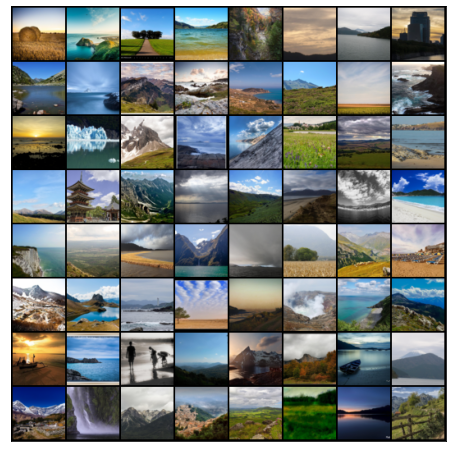

In [ ]:
show_batch(train_dataloader)

In [ ]:
def get_device():
    """Return CUDA if present and ready else return CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data, device):
    """Helper function to move Tensor dataset to device memory"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap dataloader as a class to load data to dev memory"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        """Yield / Generate batch of data on loading it to a device"""
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        """Return number of batches overall"""
        return len(self.dataloader)


In [ ]:
device = get_device()
device

device(type='cuda')

In [ ]:
# Replace the existing train dataloader class to run from the default device memory
train_dl = DeviceDataLoader(dataloader=train_dataloader, device=device)

## A Discriminator Network

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # Input of 3 channels, 64 x 64 pixel image, 2 strides per step and a pixel padding of 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    # Normalize batch to avoid extreme values having too much of an effect on the overall weights
    nn.BatchNorm2d(64),
    # LeakyReLU to selectively allow small negative values, i.e. y x 0.2
    nn.LeakyReLU(0.2, inplace=True), # Output dims: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True), # Output dims: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True), # Output dims:  256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True), # Output dims: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False), # Output dims: 1 x 1 x 1

    nn.Flatten(), # Flatten into single vector
    nn.Sigmoid() # Sigmoid activator to give out a fuzzy value range(0 - 1)
)

In [ ]:
# Move discriminator weights and params to device memory
discriminator = to_device(discriminator, device)

## Generator Neural Network

Requirements:
1. Latent Tensor, i.e. a vector of randomly initialized values
2. The usage of a ConvTranspose2d layer which is the exact opposite of the Conv2d layer, i.e. it infers image pixel values from the randomly initialized seed factored with the weigths.

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # Input is a randomly seeded 1D vector of the arbitrarily chosen latent_size
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True), # Output dims: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True), # Output dims: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True), # Output dims: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True), # Output dims: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh() # Output Dim: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


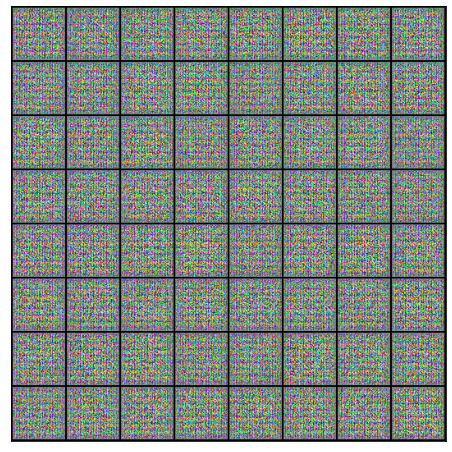

In [ ]:
rand_tensor = torch.randn(batch_size, latent_size, 1, 1) # Random latent tensors with the added batch dimension
fake_images = generator(rand_tensor)
print(fake_images.shape)
plot_images(fake_images)

In [ ]:
# Move discriminator weights and params to device memory
generator = to_device(generator, device)

## Train Discriminator

In [ ]:
def train_discriminator(real_images, opt_d):
    # Reset discriminator gradients
    opt_d.zero_grad()

    # Pass in batch of real images
    real_preds = discriminator(real_images)
    # A target tensor vector of 1s to say that the real images are actually real during training
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    # Loss function for the real predictions using the binary cross entropy loss fn
    # print("real_preds shape: ", real_preds.shape)
    # print("real_targets shape: ", real_targets.shape)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    # Mean of real_predictions
    real_score = torch.mean(real_preds).item()

    # Generate fake images using generator
    latent_tensor = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent_tensor)

    # Pass fake images through the discriminator for judgement
    fake_preds = discriminator(fake_images)
    # Tensor vector of 0s to let the discriminator know that the images are fake in nature
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    # Loss function using BCE
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    # Mean of fake_predictions
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    # Perform gradient descent to adjust discriminator weights
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

## Train Generator

In [ ]:
def train_generator(opt_g):
    """
    We generate a batch of images using the generator. We then calculate the loss by setting
    the target tensor vector as a tensor vector of ones, this is to try and fool the
    discriminator into thinking these images are real.
    """

    # Reset generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent_tensor = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent_tensor)

    # Try to fool the discriminator now
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device) # Imp.
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

## Save generated images sequentially to disk for visual reference on performance

In [ ]:
from torchvision.utils import save_image
import os

save_dir = "generated"
os.makedirs(save_dir, exist_ok=True)

def save_generated(index, latent_tensor, show=True):
    fake_images = generator(latent_tensor)
    fake_name = "gen-img-{0:0=4d}.png".format(index)
    save_image(denormalize(fake_images), os.path.join(save_dir, fake_name), nrow=8)
    print("Saving ", fake_name)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
# Define a fixed latent_tensor seed for training purposes
fixed_latent_tensor = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving  gen-img-0000.png


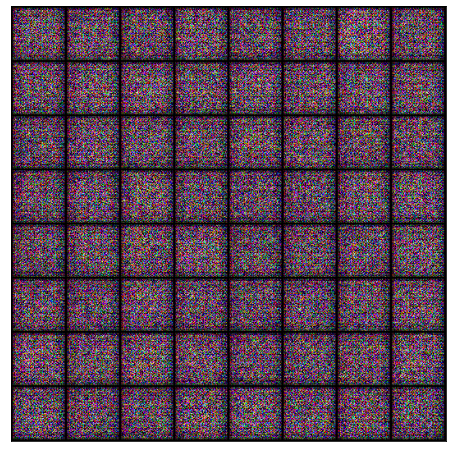

In [ ]:
save_generated(0, fixed_latent_tensor)

## Training loop to train both the generator and discriminator in parallel

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    # Clear on board cache on the CUDA
    torch.cuda.empty_cache()

    # Lists for losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train the discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train the generator
            loss_g = train_generator(opt_g)

        # Record metrics
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log metrics per epoch
        print("Epoch [{}], loss_d: {:.4f} loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, loss_g, loss_d, real_score, fake_score
        ))

        # Save generated samples
        save_generated(epoch+start_idx, fixed_latent_tensor, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [ ]:
lr = 0.0003

In [ ]:
history = fit(25, lr)


Epoch [1], loss_d: 13.1843 loss_g: 0.1855, real_score: 0.8542, fake_score: 0.0000
Saving  gen-img-0001.png



Epoch [2], loss_d: 5.3661 loss_g: 0.1351, real_score: 0.8928, fake_score: 0.0057
Saving  gen-img-0002.png



Epoch [3], loss_d: 5.9163 loss_g: 0.0543, real_score: 0.9577, fake_score: 0.0099
Saving  gen-img-0003.png



Epoch [4], loss_d: 5.8090 loss_g: 0.0522, real_score: 0.9708, fake_score: 0.0211
Saving  gen-img-0004.png



Epoch [5], loss_d: 3.1166 loss_g: 0.4562, real_score: 0.8070, fake_score: 0.1784
Saving  gen-img-0005.png



Epoch [6], loss_d: 7.2510 loss_g: 0.3711, real_score: 0.9441, fake_score: 0.2536
Saving  gen-img-0006.png



Epoch [7], loss_d: 7.0076 loss_g: 0.1919, real_score: 0.9508, fake_score: 0.1220
Saving  gen-img-0007.png



Epoch [8], loss_d: 6.7904 loss_g: 0.0717, real_score: 0.9690, fake_score: 0.0390
Saving  gen-img-0008.png



Epoch [9], loss_d: 7.3008 loss_g: 2.5806, real_score: 0.1946, fake_score: 0.0017
Saving  gen-img-0009.png



Epoch [10], loss_d: 2.6522 loss_g: 0.2943, real_score: 0.8907, fake_score: 0.1491
Saving  gen-img-0010.png



Epoch [11], loss_d: 1.6317 loss_g: 0.9489, real_score: 0.7362, fake_score: 0.4063
Saving  gen-img-0011.png



Epoch [12], loss_d: 2.8097 loss_g: 0.6034, real_score: 0.8676, fake_score: 0.3441
Saving  gen-img-0012.png



Epoch [13], loss_d: 2.8048 loss_g: 0.5649, real_score: 0.7916, fake_score: 0.2513
Saving  gen-img-0013.png



Epoch [14], loss_d: 1.0435 loss_g: 1.4922, real_score: 0.3046, fake_score: 0.0900
Saving  gen-img-0014.png



Epoch [15], loss_d: 2.1676 loss_g: 0.5056, real_score: 0.7033, fake_score: 0.1111
Saving  gen-img-0015.png



Epoch [16], loss_d: 0.7471 loss_g: 1.4099, real_score: 0.3493, fake_score: 0.0161
Saving  gen-img-0016.png



Epoch [17], loss_d: 2.6255 loss_g: 0.4293, real_score: 0.8312, fake_score: 0.2033
Saving  gen-img-0017.png



Epoch [18], loss_d: 3.3382 loss_g: 0.6990, real_score: 0.7908, fake_score: 0.3365
Saving  gen-img-0018.png



Epoch [19], loss_d: 2.3498 loss_g: 0.6680, real_score: 0.6989, fake_score: 0.2186
Saving  gen-img-0019.png



Epoch [20], loss_d: 4.2245 loss_g: 0.5733, real_score: 0.9335, fake_score: 0.3637
Saving  gen-img-0020.png



Epoch [21], loss_d: 3.3536 loss_g: 0.6934, real_score: 0.5439, fake_score: 0.0210
Saving  gen-img-0021.png



Epoch [22], loss_d: 2.5080 loss_g: 0.4533, real_score: 0.7304, fake_score: 0.0916
Saving  gen-img-0022.png



Epoch [23], loss_d: 2.9755 loss_g: 0.8983, real_score: 0.6806, fake_score: 0.3272
Saving  gen-img-0023.png



Epoch [24], loss_d: 2.1556 loss_g: 0.4165, real_score: 0.7917, fake_score: 0.1515
Saving  gen-img-0024.png



Epoch [25], loss_d: 2.7651 loss_g: 0.4789, real_score: 0.7945, fake_score: 0.1996
Saving  gen-img-0025.png


In [ ]:
torch.save(generator.state_dict(), "Generator_25.pth")
torch.save(discriminator.state_dict(), "Discriminator_25.pth")

In [ ]:
torch.save(generator.state_dict(), "Generator_25.pth")
torch.save(discriminator.state_dict(), "Discriminator_25.pth")

In [ ]:
history = fit(50, lr)


Epoch [1], loss_d: 3.0047 loss_g: 0.5910, real_score: 0.8397, fake_score: 0.2935
Saving  gen-img-0001.png



Epoch [2], loss_d: 4.3688 loss_g: 0.6670, real_score: 0.8417, fake_score: 0.3498
Saving  gen-img-0002.png



Epoch [3], loss_d: 7.4307 loss_g: 1.2452, real_score: 0.9614, fake_score: 0.6559
Saving  gen-img-0003.png



Epoch [4], loss_d: 8.1277 loss_g: 1.4050, real_score: 0.9766, fake_score: 0.7050
Saving  gen-img-0004.png



Epoch [5], loss_d: 3.8806 loss_g: 0.3828, real_score: 0.8752, fake_score: 0.2000
Saving  gen-img-0005.png



Epoch [6], loss_d: 5.2524 loss_g: 0.5902, real_score: 0.9005, fake_score: 0.3475
Saving  gen-img-0006.png



Epoch [7], loss_d: 5.3135 loss_g: 0.4184, real_score: 0.9572, fake_score: 0.2799
Saving  gen-img-0007.png



Epoch [8], loss_d: 2.6883 loss_g: 1.1738, real_score: 0.3754, fake_score: 0.0123
Saving  gen-img-0008.png



Epoch [9], loss_d: 4.9942 loss_g: 0.4233, real_score: 0.8938, fake_score: 0.2515
Saving  gen-img-0009.png



Epoch [10], loss_d: 5.8593 loss_g: 0.6701, real_score: 0.9047, fake_score: 0.3948
Saving  gen-img-0010.png



Epoch [11], loss_d: 4.8624 loss_g: 0.2849, real_score: 0.9146, fake_score: 0.1660
Saving  gen-img-0011.png



Epoch [12], loss_d: 5.4553 loss_g: 0.7056, real_score: 0.8778, fake_score: 0.3801
Saving  gen-img-0012.png



Epoch [13], loss_d: 3.0330 loss_g: 0.3196, real_score: 0.8676, fake_score: 0.1489
Saving  gen-img-0013.png



Epoch [14], loss_d: 4.3861 loss_g: 0.4528, real_score: 0.8300, fake_score: 0.2080
Saving  gen-img-0014.png



Epoch [15], loss_d: 3.8883 loss_g: 0.2416, real_score: 0.8259, fake_score: 0.0337
Saving  gen-img-0015.png



Epoch [16], loss_d: 4.8125 loss_g: 0.5350, real_score: 0.8859, fake_score: 0.3047
Saving  gen-img-0016.png



Epoch [17], loss_d: 3.7867 loss_g: 0.3826, real_score: 0.7407, fake_score: 0.0368
Saving  gen-img-0017.png



Epoch [18], loss_d: 2.5408 loss_g: 0.5193, real_score: 0.7409, fake_score: 0.1602
Saving  gen-img-0018.png



Epoch [19], loss_d: 2.5950 loss_g: 0.6241, real_score: 0.6164, fake_score: 0.0808
Saving  gen-img-0019.png



Epoch [20], loss_d: 3.6127 loss_g: 0.2172, real_score: 0.8943, fake_score: 0.0902
Saving  gen-img-0020.png



Epoch [21], loss_d: 5.7151 loss_g: 0.6128, real_score: 0.9794, fake_score: 0.4048
Saving  gen-img-0021.png



Epoch [22], loss_d: 2.5341 loss_g: 0.3677, real_score: 0.8084, fake_score: 0.1233
Saving  gen-img-0022.png



Epoch [23], loss_d: 2.5240 loss_g: 0.3363, real_score: 0.8576, fake_score: 0.1435
Saving  gen-img-0023.png



Epoch [24], loss_d: 2.2509 loss_g: 0.4026, real_score: 0.8071, fake_score: 0.1402
Saving  gen-img-0024.png



Epoch [25], loss_d: 2.5631 loss_g: 0.2735, real_score: 0.9055, fake_score: 0.1507
Saving  gen-img-0025.png



Epoch [26], loss_d: 9.2864 loss_g: 2.0944, real_score: 0.9908, fake_score: 0.8154
Saving  gen-img-0026.png



Epoch [27], loss_d: 2.9810 loss_g: 0.4465, real_score: 0.7247, fake_score: 0.0801
Saving  gen-img-0027.png



Epoch [28], loss_d: 1.4469 loss_g: 0.5771, real_score: 0.6384, fake_score: 0.0614
Saving  gen-img-0028.png



Epoch [29], loss_d: 1.5687 loss_g: 0.3675, real_score: 0.7604, fake_score: 0.0611
Saving  gen-img-0029.png



Epoch [30], loss_d: 4.2380 loss_g: 0.3978, real_score: 0.8904, fake_score: 0.2246
Saving  gen-img-0030.png



Epoch [31], loss_d: 7.3905 loss_g: 0.8557, real_score: 0.9771, fake_score: 0.5028
Saving  gen-img-0031.png



Epoch [32], loss_d: 3.9864 loss_g: 0.3886, real_score: 0.7115, fake_score: 0.0129
Saving  gen-img-0032.png



Epoch [33], loss_d: 2.9117 loss_g: 0.4236, real_score: 0.8163, fake_score: 0.1652
Saving  gen-img-0033.png



Epoch [34], loss_d: 4.6820 loss_g: 0.5357, real_score: 0.9564, fake_score: 0.3337
Saving  gen-img-0034.png



Epoch [35], loss_d: 2.7149 loss_g: 0.3080, real_score: 0.7783, fake_score: 0.0367
Saving  gen-img-0035.png



Epoch [36], loss_d: 2.8269 loss_g: 0.3452, real_score: 0.8602, fake_score: 0.1601
Saving  gen-img-0036.png



Epoch [37], loss_d: 4.4323 loss_g: 0.4917, real_score: 0.9321, fake_score: 0.3178
Saving  gen-img-0037.png



Epoch [38], loss_d: 3.7491 loss_g: 0.1859, real_score: 0.8861, fake_score: 0.0520
Saving  gen-img-0038.png



Epoch [39], loss_d: 3.7934 loss_g: 0.2384, real_score: 0.8606, fake_score: 0.0718
Saving  gen-img-0039.png



Epoch [40], loss_d: 4.1487 loss_g: 0.2648, real_score: 0.9265, fake_score: 0.1555
Saving  gen-img-0040.png



Epoch [41], loss_d: 3.9721 loss_g: 0.6262, real_score: 0.8431, fake_score: 0.3246
Saving  gen-img-0041.png



Epoch [42], loss_d: 3.2552 loss_g: 0.2755, real_score: 0.8498, fake_score: 0.0885
Saving  gen-img-0042.png



Epoch [43], loss_d: 4.6676 loss_g: 0.4910, real_score: 0.8770, fake_score: 0.2710
Saving  gen-img-0043.png



Epoch [44], loss_d: 5.7149 loss_g: 0.9624, real_score: 0.9934, fake_score: 0.5264
Saving  gen-img-0044.png



Epoch [45], loss_d: 4.6350 loss_g: 0.2428, real_score: 0.9484, fake_score: 0.1606
Saving  gen-img-0045.png



Epoch [46], loss_d: 2.3377 loss_g: 0.7510, real_score: 0.5339, fake_score: 0.0116
Saving  gen-img-0046.png



Epoch [47], loss_d: 0.7074 loss_g: 2.2556, real_score: 0.1682, fake_score: 0.0350
Saving  gen-img-0047.png



Epoch [48], loss_d: 3.1076 loss_g: 0.7729, real_score: 0.5139, fake_score: 0.0058
Saving  gen-img-0048.png



Epoch [49], loss_d: 4.1770 loss_g: 0.4014, real_score: 0.8997, fake_score: 0.2288
Saving  gen-img-0049.png



Epoch [50], loss_d: 4.8316 loss_g: 0.2903, real_score: 0.9678, fake_score: 0.2069
Saving  gen-img-0050.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
discriminator.load_state_dict(torch.load("Discriminator_75.pth"))
generator.load_state_dict(torch.load("Generator_75.pth"))

<All keys matched successfully>

In [ ]:
history = fit(25, lr)


Epoch [1], loss_d: 4.1507 loss_g: 0.2892, real_score: 0.8729, fake_score: 0.1190
Saving  gen-img-0001.png



Epoch [2], loss_d: 3.8505 loss_g: 0.4264, real_score: 0.8703, fake_score: 0.2087
Saving  gen-img-0002.png



Epoch [3], loss_d: 6.2623 loss_g: 0.2901, real_score: 0.9593, fake_score: 0.1916
Saving  gen-img-0003.png



Epoch [4], loss_d: 2.9039 loss_g: 0.2540, real_score: 0.9845, fake_score: 0.1982
Saving  gen-img-0004.png



Epoch [5], loss_d: 3.4139 loss_g: 0.2728, real_score: 0.8803, fake_score: 0.1211
Saving  gen-img-0005.png



Epoch [6], loss_d: 2.8045 loss_g: 0.2151, real_score: 0.8544, fake_score: 0.0447
Saving  gen-img-0006.png



Epoch [7], loss_d: 4.0330 loss_g: 0.2135, real_score: 0.9510, fake_score: 0.1401
Saving  gen-img-0007.png



Epoch [8], loss_d: 2.3109 loss_g: 0.3022, real_score: 0.7826, fake_score: 0.0309
Saving  gen-img-0008.png



Epoch [9], loss_d: 5.8758 loss_g: 0.9895, real_score: 0.9434, fake_score: 0.4710
Saving  gen-img-0009.png



Epoch [10], loss_d: 4.7515 loss_g: 0.2791, real_score: 0.9537, fake_score: 0.1913
Saving  gen-img-0010.png



Epoch [11], loss_d: 3.4385 loss_g: 0.3659, real_score: 0.7774, fake_score: 0.0745
Saving  gen-img-0011.png



Epoch [12], loss_d: 10.3952 loss_g: 1.9539, real_score: 0.9974, fake_score: 0.7704
Saving  gen-img-0012.png



Epoch [13], loss_d: 4.1132 loss_g: 0.1737, real_score: 0.9116, fake_score: 0.0715
Saving  gen-img-0013.png



Epoch [14], loss_d: 5.8078 loss_g: 0.2347, real_score: 0.9807, fake_score: 0.1718
Saving  gen-img-0014.png



Epoch [15], loss_d: 3.3999 loss_g: 0.3410, real_score: 0.8009, fake_score: 0.0870
Saving  gen-img-0015.png



Epoch [16], loss_d: 3.5027 loss_g: 0.1591, real_score: 0.8787, fake_score: 0.0193
Saving  gen-img-0016.png



Epoch [17], loss_d: 2.0118 loss_g: 4.5643, real_score: 0.0381, fake_score: 0.0001
Saving  gen-img-0017.png



Epoch [18], loss_d: 5.0018 loss_g: 0.3684, real_score: 0.9327, fake_score: 0.2230
Saving  gen-img-0018.png



Epoch [19], loss_d: 3.8148 loss_g: 0.2467, real_score: 0.8733, fake_score: 0.0942
Saving  gen-img-0019.png



Epoch [20], loss_d: 4.7125 loss_g: 0.3725, real_score: 0.9228, fake_score: 0.2166
Saving  gen-img-0020.png



Epoch [21], loss_d: 4.8559 loss_g: 0.2363, real_score: 0.9539, fake_score: 0.1530
Saving  gen-img-0021.png



Epoch [22], loss_d: 4.4929 loss_g: 0.1657, real_score: 0.9348, fake_score: 0.0871
Saving  gen-img-0022.png



Epoch [23], loss_d: 6.9416 loss_g: 0.3891, real_score: 0.9761, fake_score: 0.2842
Saving  gen-img-0023.png



Epoch [24], loss_d: 3.8341 loss_g: 0.4132, real_score: 0.8683, fake_score: 0.2015
Saving  gen-img-0024.png



Epoch [25], loss_d: 5.2960 loss_g: 0.4104, real_score: 0.8678, fake_score: 0.1923
Saving  gen-img-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

torch.save(generator.state_dict(), "Generator_100.pth")
torch.save(discriminator.state_dict(), "Discriminator_100.pth")

In [ ]:
discriminator.load_state_dict(torch.load("Discriminator_100.pth"))
generator.load_state_dict(torch.load("Generator_100.pth"))

<All keys matched successfully>

In [ ]:
history = fit(25, 0.0004)


Epoch [1], loss_d: 4.8080 loss_g: 0.3396, real_score: 0.9498, fake_score: 0.2259
Saving  gen-img-0001.png



Epoch [2], loss_d: 1.6968 loss_g: 0.9131, real_score: 0.4638, fake_score: 0.0127
Saving  gen-img-0002.png



Epoch [3], loss_d: 3.2533 loss_g: 0.5175, real_score: 0.6526, fake_score: 0.0068
Saving  gen-img-0003.png



Epoch [4], loss_d: 3.0204 loss_g: 0.6055, real_score: 0.6430, fake_score: 0.0292
Saving  gen-img-0004.png



Epoch [5], loss_d: 8.7950 loss_g: 1.1336, real_score: 0.9867, fake_score: 0.6107
Saving  gen-img-0005.png



Epoch [6], loss_d: 7.9642 loss_g: 0.2782, real_score: 0.9740, fake_score: 0.2050
Saving  gen-img-0006.png



Epoch [7], loss_d: 8.6773 loss_g: 2.2379, real_score: 0.9821, fake_score: 0.7972
Saving  gen-img-0007.png



Epoch [8], loss_d: 4.2263 loss_g: 0.3710, real_score: 0.8709, fake_score: 0.1736
Saving  gen-img-0008.png



Epoch [9], loss_d: 5.0225 loss_g: 0.2343, real_score: 0.9117, fake_score: 0.1146
Saving  gen-img-0009.png



Epoch [10], loss_d: 3.7373 loss_g: 0.1319, real_score: 0.9230, fake_score: 0.0460
Saving  gen-img-0010.png



Epoch [11], loss_d: 7.6257 loss_g: 0.8121, real_score: 0.9561, fake_score: 0.4554
Saving  gen-img-0011.png



Epoch [12], loss_d: 2.0367 loss_g: 0.1265, real_score: 0.8985, fake_score: 0.0134
Saving  gen-img-0012.png



Epoch [13], loss_d: 3.8182 loss_g: 0.4843, real_score: 0.6795, fake_score: 0.0165
Saving  gen-img-0013.png



Epoch [14], loss_d: 3.9985 loss_g: 0.1184, real_score: 0.9139, fake_score: 0.0241
Saving  gen-img-0014.png



Epoch [15], loss_d: 5.9204 loss_g: 1.0475, real_score: 0.9276, fake_score: 0.5012
Saving  gen-img-0015.png



Epoch [16], loss_d: 3.8275 loss_g: 0.3570, real_score: 0.7549, fake_score: 0.0185
Saving  gen-img-0016.png



Epoch [17], loss_d: 4.1007 loss_g: 0.5662, real_score: 0.9400, fake_score: 0.3427
Saving  gen-img-0017.png



Epoch [18], loss_d: 3.5859 loss_g: 0.3859, real_score: 0.8221, fake_score: 0.1415
Saving  gen-img-0018.png



Epoch [19], loss_d: 3.9145 loss_g: 0.3542, real_score: 0.7379, fake_score: 0.0091
Saving  gen-img-0019.png



Epoch [20], loss_d: 5.4637 loss_g: 0.2194, real_score: 0.9685, fake_score: 0.1627
Saving  gen-img-0020.png



Epoch [21], loss_d: 5.3992 loss_g: 0.1129, real_score: 0.9571, fake_score: 0.0632
Saving  gen-img-0021.png



Epoch [22], loss_d: 1.9047 loss_g: 1.1553, real_score: 0.4602, fake_score: 0.1152
Saving  gen-img-0022.png



Epoch [23], loss_d: 3.6235 loss_g: 0.2673, real_score: 0.8887, fake_score: 0.1160
Saving  gen-img-0023.png



Epoch [24], loss_d: 4.0395 loss_g: 0.1748, real_score: 0.9189, fake_score: 0.0766
Saving  gen-img-0024.png



Epoch [25], loss_d: 1.6719 loss_g: 0.3977, real_score: 0.7556, fake_score: 0.0879
Saving  gen-img-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

torch.save(generator.state_dict(), "Generator_125.pth")
torch.save(discriminator.state_dict(), "Discriminator_125.pth")

In [ ]:
history = fit(75, 0.0002)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving  gen-img-0555.png


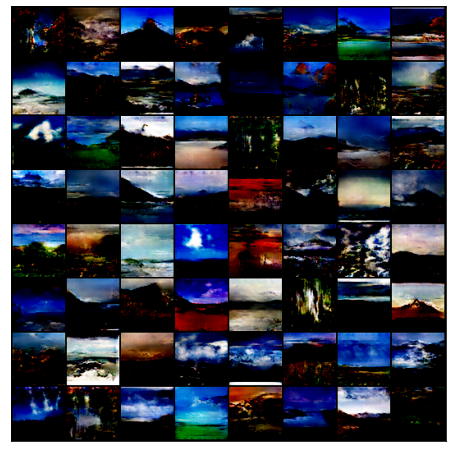

In [ ]:
# Predict from random sample input
random_tensor = torch.randn(64, latent_size, 1, 1, device=device)
save_generated(555, random_tensor)

In [ ]:
# Final Log
losses_g, losses_d, real_scores, fake_scores = history

torch.save(generator.state_dict(), "Generator_170.pth")
torch.save(discriminator.state_dict(), "Discriminator_170.pth")